In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
   
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/testset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/testset/trimmed_001.mp4
/kaggle/input/testset/lsa-padded_matrix_file.csv
/kaggle/input/testset/001.mp4
/kaggle/input/testset/lsa-train-matrix_file.csv
/kaggle/input/testset/matrix_file.csv
/kaggle/input/testset/lsa-test-matrix_file.csv


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import csv
import ast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

In [4]:
#comment this when using full dataset

#Get all skeleton locations into a single cell

import csv

# # Specify the input and output file paths
# input_path = '/kaggle/input/testset/lsa-padded_matrix_file.csv'
# output_path = '/kaggle/working/selected_classes_padded_matrix.csv'

# selected_classes = [1,2,3,4,30,31,33,34,35,50]


# # Open the input CSV file and the output CSV file
# with open(input_path, 'r') as input_file, open(output_path, 'w', newline='') as output_file:

#     # Create a CSV reader object and a CSV writer object
#     reader = csv.reader(input_file)
#     writer = csv.writer(output_file)

#     # Iterate over each row in the input CSV file
#     for row in reader:

#         clss = row[-1]
        
#         if (int(clss) in selected_classes):
            
#             row = row[:-1] + [selected_classes.index(int(clss))] 
            
#             writer.writerow(row)

In [5]:
# Code for loading the data (unchanged)
# input_file = "/kaggle/working/selected_classes_padded_matrix.csv"
input_file = "/kaggle/input/testset/lsa-padded_matrix_file.csv"


values = []
matrix_labels = []
num_rows = 0

with open(input_file, "r") as f_input:
    reader = csv.reader(f_input)
    for row in reader:
        row_values = []
        for i in range(len(row) - 1):
            column_value = ast.literal_eval(row[i])
            row_values.append(column_value)
        values.append(torch.tensor(row_values))
        matrix_labels.append(ast.literal_eval(row[-1]))
        num_rows += 1

In [6]:
def sample_triplets(embeddings, labels, margin):
    anchor_indices = torch.arange(len(embeddings))
    positive_indices = torch.empty(len(embeddings), dtype=torch.long)
    negative_indices = torch.empty(len(embeddings), dtype=torch.long)

    for i, label in enumerate(labels):
        # Sample positive instances
        positive_candidates = (labels == label).nonzero(as_tuple=False).view(-1)
        positive_candidates = positive_candidates[positive_candidates != i]

        if len(positive_candidates) > 0:
            positive_indices[i] = positive_candidates[torch.randint(0, len(positive_candidates), (1,))]
        else:
            positive_indices[i] = i

        # Sample negative instances
        negative_candidates = (labels != label).nonzero(as_tuple=False).view(-1)
        anchor_embedding = embeddings[i]
        negative_embeddings = embeddings[negative_candidates]
        pos_distance = torch.norm(anchor_embedding - embeddings[positive_indices[i]])

        neg_distances = torch.norm(anchor_embedding.unsqueeze(0) - negative_embeddings, dim=1)
        semi_hard_negatives = (neg_distances > (pos_distance - margin)) & (neg_distances < (pos_distance + margin))

        if torch.any(semi_hard_negatives):
            negative_indices[i] = negative_candidates[semi_hard_negatives][torch.randint(0, semi_hard_negatives.sum(), (1,))]
        else:
            negative_indices[i] = negative_candidates[neg_distances.argmin()]

    anchor = embeddings[anchor_indices]
    positive = embeddings[positive_indices]
    negative = embeddings[negative_indices]
    return anchor, positive, negative

In [7]:
# Triplet loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = F.pairwise_distance(anchor,positive)
        neg_distance = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_distance - neg_distance + self.margin)
        return loss.mean()

In [8]:
# Define the dataset class
class SkeletonDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_features, d_model=32, nhead=16, num_layers=1,n_classes=64):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(n_features, d_model)
        self.positional_encoding = self.generate_positional_encoding(d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_layers
        )
        self.classification_head = nn.Linear(d_model, n_classes)

    def generate_positional_encoding(self, d_model, max_len=243):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.embedding(x)
        x = x + self.positional_encoding[:, : x.size(1)]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        class_logits = self.classification_head(x)
        return x, class_logits

Epoch 1/70, Train Loss: 1.9378, Triplet Loss: 1.0305, Cross Entropy Loss: 4.0547, Validation Loss: 1.8150
Epoch 2/70, Train Loss: 1.6970, Triplet Loss: 0.8074, Cross Entropy Loss: 3.7729, Validation Loss: 1.5962
Epoch 3/70, Train Loss: 1.5305, Triplet Loss: 0.7026, Cross Entropy Loss: 3.4625, Validation Loss: 1.4051
Epoch 4/70, Train Loss: 1.3842, Triplet Loss: 0.6123, Cross Entropy Loss: 3.1852, Validation Loss: 1.2626
Epoch 5/70, Train Loss: 1.2727, Triplet Loss: 0.5692, Cross Entropy Loss: 2.9140, Validation Loss: 1.1579
Epoch 6/70, Train Loss: 1.1493, Triplet Loss: 0.4879, Cross Entropy Loss: 2.6926, Validation Loss: 1.0539
Epoch 7/70, Train Loss: 1.0528, Triplet Loss: 0.4364, Cross Entropy Loss: 2.4912, Validation Loss: 1.0307
Epoch 8/70, Train Loss: 1.0299, Triplet Loss: 0.4566, Cross Entropy Loss: 2.3674, Validation Loss: 0.9741
Epoch 9/70, Train Loss: 0.9587, Triplet Loss: 0.4327, Cross Entropy Loss: 2.1860, Validation Loss: 0.9385
Epoch 10/70, Train Loss: 0.9142, Triplet Loss:

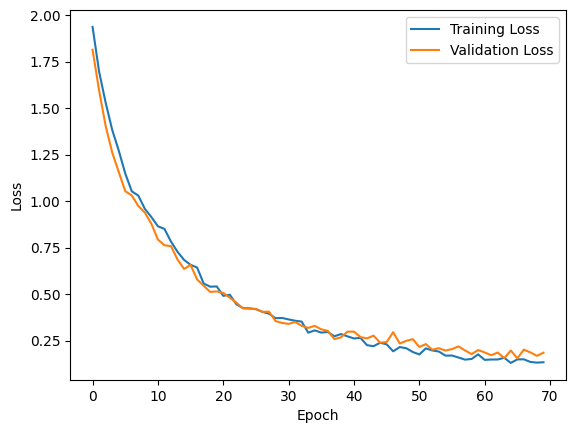

In [10]:
# Split the dataset into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    torch.stack(values), torch.tensor(matrix_labels), test_size=0.4, random_state=42, stratify=torch.tensor(matrix_labels)
)

validation_data, test_data, validation_labels, test_labels = train_test_split(
    test_data, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Create train, validation, and test datasets
train_dataset = SkeletonDataset(train_data, train_labels)
validation_dataset = SkeletonDataset(validation_data, validation_labels)
test_dataset = SkeletonDataset(test_data, test_labels)

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = TransformerEncoder(114)
triplet_loss_criterion = TripletLoss()
cross_entropy_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

train_losses = []
validation_losses = []
train_triplet_losses = []
train_cross_entropy_losses = []

alpha = 0.7  # weight for the triplet loss

num_epochs = 70   ##===========================================EPOCHS
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    epoch_triplet_loss = 0
    epoch_cross_entropy_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        embeddings, class_logits = model(data)
        anchor, positive, negative = sample_triplets(embeddings, labels, margin=2.0)
        triplet_loss = triplet_loss_criterion(anchor, positive, negative)
        cross_entropy_loss = cross_entropy_criterion(class_logits, labels)
        loss = alpha * triplet_loss + (1 - alpha) * cross_entropy_loss
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        epoch_triplet_loss += triplet_loss.item()
        epoch_cross_entropy_loss += cross_entropy_loss.item()

    epoch_train_loss /= len(train_loader)
    epoch_triplet_loss /= len(train_loader)
    epoch_cross_entropy_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    train_triplet_losses.append(epoch_triplet_loss)
    train_cross_entropy_losses.append(epoch_cross_entropy_loss)

    # Calculate validation loss
    model.eval()
    epoch_validation_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(validation_loader):
            embeddings, class_logits = model(data)
            anchor, positive, negative = sample_triplets(embeddings, labels, margin=2.0)
            triplet_loss = triplet_loss_criterion(anchor, positive, negative)
            cross_entropy_loss = cross_entropy_criterion(class_logits, labels)
            loss = alpha * triplet_loss + (1 - alpha) * cross_entropy_loss
            epoch_validation_loss += loss.item()

    epoch_validation_loss /= len(validation_loader)
    validation_losses.append(epoch_validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Triplet Loss: {epoch_triplet_loss:.4f}, Cross Entropy Loss: {epoch_cross_entropy_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}")

    # Save the model
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pt")


# Plot training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# evaluation

In [11]:
# Extract embeddings for the test set
model.eval()
test_embeddings = []
test_labels_list = []

with torch.no_grad():
    for data, labels in train_loader:
        embeddings,_ = model(data)
        test_embeddings.append(embeddings)
        test_labels_list.append(labels)
        
with torch.no_grad():
    for data, labels in test_loader:
        embeddings,_ = model(data)
        test_embeddings.append(embeddings)
        test_labels_list.append(labels)
        
with torch.no_grad():
    for data, labels in validation_loader:
        embeddings,_ = model(data)
        test_embeddings.append(embeddings)
        test_labels_list.append(labels)

test_embeddings = torch.cat(test_embeddings).cpu().numpy()
test_labels_list = torch.cat(test_labels_list).cpu().numpy()

In [12]:
import plotly.express as px
import plotly.colors as colors
from itertools import cycle

tsne = TSNE(n_components=2, random_state=42)  
test_embeddings_2d = tsne.fit_transform(test_embeddings) 

le = LabelEncoder()
test_labels_int = le.fit_transform(test_labels_list)

n_classes = 64 ##==========================================CLASSES
color_scale = cycle(colors.qualitative.Plotly)

fig = go.Figure()
for i in range(n_classes):
    class_mask = test_labels_int == i
    fig.add_trace(
        go.Scatter(
            x=test_embeddings_2d[class_mask, 0],  
            y=test_embeddings_2d[class_mask, 1],  
            mode="markers",
            name=str(le.inverse_transform([i])[0]),
            marker=dict(size=3, color=next(color_scale)),
        ),
    )

fig.update_layout(height=600, width=800, title_text="Embeddings Visualizations (2D)")
fig.show()